In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
plt.style.use(FIG_ROOT/"base.mplstyle")

In [5]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [6]:
from collections import defaultdict as ddict
def fil_name2paras(fil_name):
    """plz be careful about 0.1 and 1
    """
    tmp = fil_name.split("_")
    paras = {}
    for itm in tmp:
        if '--' in itm:
            k, v = itm.split("--")
            v = f"0.{v}"
        elif '-' in itm:
            k, v = itm.split("-")
            # to be compatible with old simu
            if v.startswith("0"):
                v = f"0.{v}"
        else:
            continue
        
        if k.startswith("T"):
            k = "n_T"
        elif k.startswith("decay"):
            k = "weight_decay"
        elif k.startswith("infeat"):
            k = "n_infeat"
        paras[k] = float(v)
    paras["rep"] = int(tmp[1])
    return paras


In [16]:
# get results of DDIM and naive
def _add_res(res, key, dict_res):
    if key not in res.keys():
        return None
    dict_res["Len"].append(res[key][-1])
    dict_res["ITE"].append(res[key][0])
    dict_res["method"].append(key)
    for ky, v in cur_paras.items():
        dict_res[ky].append(v)
        
setting = "setting4"
#setting = "setting4"
d = 100
res_dir = RES_ROOT/f"simu_{setting}_d{d}_n3000"
all_fils = list(res_dir.glob("*n_T-*.pkl"));
our_res = ddict(list)
for fil in all_fils:
    cur_paras = fil_name2paras(fil.stem);
    res = load_pkl(fil, verbose=False);
    
    _add_res(res, key="DDIM", dict_res=our_res)
    _add_res(res, key="DDIM_val", dict_res=our_res)
    _add_res(res, key="naive", dict_res=our_res)
    _add_res(res, key="naive_val", dict_res=our_res)
    
    for model_ix in range(500, 6000, 500):
        _add_res(res, key=f"DDIM_ep{model_ix}", dict_res=our_res)
        _add_res(res, key=f"DDIM_ep{model_ix}_val", dict_res=our_res)
        _add_res(res, key=f"naive_ep{model_ix}", dict_res=our_res)
        _add_res(res, key=f"naive_ep{model_ix}_val",dict_res=our_res)
        
our_res_df = pd.DataFrame(our_res);

In [17]:
# get results of MLP
all_fils = list(res_dir.glob("*mlp*.pkl"));
mlp_res = ddict(list)
for fil in all_fils:
    cur_paras = fil_name2paras(fil.stem);
    res = load_pkl(fil, verbose=False);
    
    _add_res(res, key="mlp", dict_res=mlp_res)
    _add_res(res, key="mlp_val", dict_res=mlp_res)
    
    for model_ix in range(500, 6000, 500):
        _add_res(res, key=f"mlp_ep{model_ix}", dict_res=mlp_res)
        _add_res(res, key=f"mlp_ep{model_ix}_val", dict_res=mlp_res)
        
mlp_res_df = pd.DataFrame(mlp_res);

In [18]:
# results of CQR and CF
def _add_ores(res, key, dict_res):
    if key not in res.keys():
        return None
    dict_res["Len"].append(res[key][-1])
    dict_res["ITE"].append(res[key][0])
    dict_res["method"].append(key)
    dict_res["rep"].append(_get_rep(ofil))
_get_rep = lambda p: int(p.stem.split("_")[1])
ofils = list(res_dir.glob("*other*.pkl"));
other_res = ddict(list);
for ofil in ofils:
    res = load_pkl(ofil, verbose=False);
    _add_ores(res, key="CQR", dict_res=other_res)
    _add_ores(res, key="CF", dict_res=other_res)
other_res_df = pd.DataFrame(other_res);

# Select com for each rep

In [19]:
# get opt obs based on val set
def _get_opt_obs_given_repix(rep_ix, all_res_df, method_key="DDPM", cutoff=None):
    cols = ["method", "lr", "n_infeat", "n_T", "weight_decay", "upblk", "downblk", "rep"]
    kpidx = np.bitwise_and(all_res_df["rep"] == rep_ix, all_res_df["method"].map(lambda x: ("val" in x) and (method_key in x)));
    if cutoff is not None:
        kpidx = np.bitwise_and(kpidx, all_res_df["ITE"]>cutoff)
    if kpidx.sum() == 0:
        kpidx = np.bitwise_and(all_res_df["rep"] == rep_ix, all_res_df["method"].map(lambda x: ("val" in x) and (method_key in x)))
    
    best_val = all_res_df[kpidx].sort_values(by="Len").iloc[0]
    mask = np.ones(all_res_df.shape[0], dtype=bool)
    for col in cols:
        if col not in all_res_df.columns:
            continue
        if col.startswith("method"):
            #v = best_val[col]
            v = best_val[col].split("_val")[0]
            mask = np.bitwise_and(mask, all_res_df[col].isin([v]))
            
        else: 
            v = best_val[col]
            mask = np.bitwise_and(mask, all_res_df[col] == v)
    return all_res_df[mask]

In [20]:
cutoff = 0.95

# my results
our_res_df1 = our_res_df
best_res = []
for cur_rep in list(set(our_res_df1["rep"])):
    best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "naive", cutoff))
    best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "DDIM", cutoff))
    
best_res = pd.concat(best_res);
best_res1 = best_res.copy();
best_res["method"] = best_res["method"].map(lambda x: x.split("_")[0])
best_res = best_res[["Len", "ITE", "method", "rep"]];

In [21]:
mlp_best_res = []
for cur_rep in list(set(our_res_df1["rep"])):
    mlp_best_res.append(_get_opt_obs_given_repix(cur_rep, mlp_res_df, "mlp", cutoff))
    
mlp_best_res = pd.concat(mlp_best_res);
mlp_best_res1 = mlp_best_res.copy();
mlp_best_res["method"] = mlp_best_res["method"].map(lambda x: x.split("_")[0])
mlp_best_res = mlp_best_res[["Len", "ITE", "method", "rep"]];

In [22]:
# put the results together
all_res_df = pd.concat([best_res, mlp_best_res, other_res_df])
all_res_df.groupby(["method"])[["Len", "ITE"]].agg(["mean", "median", "std", "count"])

Len                      ITE                   
        mean median   std count  mean median   std count
method                                                  
CF     0.390  0.391 0.016    50 0.217  0.215 0.015    50
CQR    3.748  3.691 0.322    50 0.949  0.950 0.013    50
DDIM   4.405  4.365 0.581    50 0.948  0.947 0.014    50
mlp    5.726  5.656 0.669    50 0.939  0.939 0.015    50
naive  1.185  0.285 1.950    50 0.331  0.192 0.312    50

In [25]:
def _foo(x):
    tmp = x.split("_ep")
    if len(tmp) == 1:
        return 4000
    else:
        return int(tmp[1])

sel_cols = ["n_infeat", "lr", "downblk", "epoch", "method1"]
    
mlp_best_res1["epoch"] = mlp_best_res1["method"].map(_foo)
mlp_best_res1["method1"] = mlp_best_res1["method"].map(lambda x: x.split("_ep")[0])

best_res1["epoch"] = best_res1["method"].map(_foo)
best_res1["method1"] = best_res1["method"].map(lambda x: x.split("_ep")[0])
idxs = best_res1["method"].map(lambda x: "DDIM" in x);

df = pd.concat([mlp_best_res1[sel_cols],best_res1[idxs][sel_cols]]) 
df.groupby("method1").agg(["max", "mean", "median"])

n_infeat                    lr              downblk               \
             max    mean  median   max  mean median     max  mean median   
method1                                                                    
DDIM     256.000 171.520 128.000 0.100 0.093  0.100   3.000 2.160  3.000   
mlp      256.000 186.880 128.000 0.100 0.030  0.010   3.000 2.080  3.000   

        epoch                    
          max     mean   median  
method1                          
DDIM     4000 1030.000  500.000  
mlp      4000 1580.000 1000.000

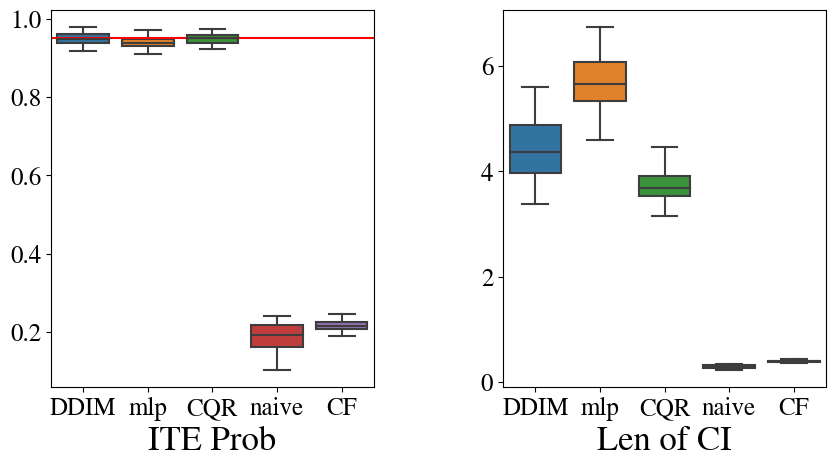

In [26]:
method_order=["DDIM", "mlp", "CQR", "naive", "CF"]
plt.subplot(121)
sns.boxplot(data=all_res_df, y="ITE", x="method", showfliers=False, order=method_order, orient='v')
plt.axhline(y=0.95, color="red");
plt.ylabel("")
plt.xlabel("ITE Prob")
plt.subplot(122)
sns.boxplot(data=all_res_df, y="Len", x="method", showfliers=False, order=method_order, orient='v')
plt.ylabel("")
plt.xlabel("Len of CI");
#plt.savefig(FIG_ROOT/f"{setting}_d{d}_wmlp.jpg")